In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dropout, Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import gc
import os
import glob

In [17]:
# Initial parameters
epochs = 50
lr = 1e-4
batch_size = 64
img_dims = (96, 96, 3)
n_splits = 5  # K-folds
data = []
labels = []

In [18]:
# Load image files from the dataset
image_files = [f for f in glob.glob(r'gender_dataset_face/**/*', recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [19]:
# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = 1 if label == "woman" else 0
    labels.append(label)

print(f"Loaded {len(data)} images with labels.")

Loaded 11135 images with labels.


In [20]:
# Preprocessing
data = np.array(data, dtype="float16")
data = preprocess_input(data)

labels = np.array(labels)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

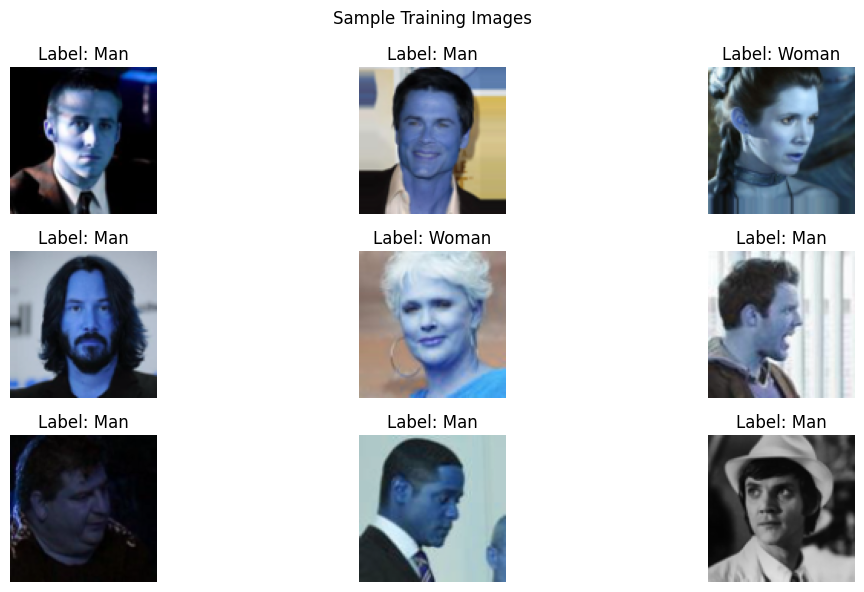

In [21]:
# Visualize sample images
plt.figure(figsize=(12, 6))

for i in range(9):
    idx = random.randint(0, len(trainX) - 1)
    
    # Ensure the image is in float32 and within [0, 1] range
    img = ((trainX[idx] + 1.0) / 2.0).astype("float32")  # Rescale from [-1,1] to [0,1]
    img = np.clip(img, 0.0, 1.0)  # Prevent values outside the valid range

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {'Woman' if np.argmax(trainY[idx]) == 1 else 'Man'}")
    plt.axis('off')

plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.savefig('Images/sample_images.png')
plt.show()


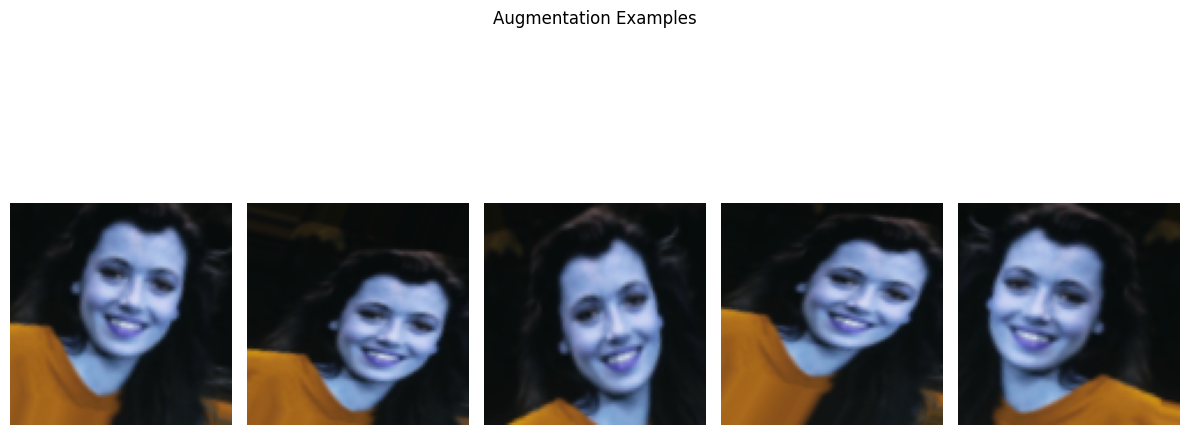

In [22]:
# Augmenting the dataset
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest"
)

# Visualize data augmentation
sample_image = trainX[0]
aug_iter = aug.flow(np.expand_dims(sample_image, axis=0), batch_size=1)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    aug_image = next(aug_iter)[0]
    aug_image = (aug_image + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]
    plt.imshow(aug_image)
    plt.axis('off')

plt.suptitle("Augmentation Examples")
plt.tight_layout()
plt.savefig('Images/augmented_examples.png')
plt.show()

In [23]:
def build_xception(input_shape=(150, 150, 3), classes=2):
    base_model = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [24]:
# Train the model
# Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

best_accuracy = 0
best_fold = -1
fold_accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(data, labels)):
    print(f"\n===== Fold {fold + 1}/{n_splits} =====")
    trainX, testX = data[train_idx], data[test_idx]
    trainY, testY = labels[train_idx], labels[test_idx]

    trainY_cat = to_categorical(trainY, num_classes=2)
    testY_cat = to_categorical(testY, num_classes=2)

    # Build and compile model
    model = build_xception(input_shape=(img_dims[0], img_dims[1], 3))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    H = model.fit(
        aug.flow(trainX, trainY_cat, batch_size=batch_size),
        validation_data=(testX, testY_cat),
        steps_per_epoch=len(trainX) // batch_size,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    # Predict and evaluate
    predY = model.predict(testX, batch_size=batch_size)
    predY = np.argmax(predY, axis=1)
    trueY = testY
    acc = accuracy_score(trueY, predY)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

    # Save best model
    if acc > best_accuracy:
        best_accuracy = acc
        best_fold = fold + 1
        model.save(f'Model/best_gender_detection_Xception_fold{best_fold}.h5')

    # Clear memory
    K.clear_session()
    del model, trainX, testX, trainY, testY, trainY_cat, testY_cat, H, predY, trueY
    gc.collect()

# Final results
print(f"\nBest Fold: {best_fold} with Accuracy: {best_accuracy:.4f}")
print(f"All Fold Accuracies: {[round(a, 4) for a in fold_accuracies]}")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")


===== Fold 1/5 =====


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_136']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7482 - loss: 0.5087 - val_accuracy: 0.8415 - val_loss: 0.3564
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 2:01 878ms/step - accuracy: 0.8594 - loss: 0.3437

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - accuracy: 0.8594 - loss: 0.3437 - val_accuracy: 0.8446 - val_loss: 0.3544
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8271 - loss: 0.3868 - val_accuracy: 0.8559 - val_loss: 0.3406
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.7969 - loss: 0.4199 - val_accuracy: 0.8563 - val_loss: 0.3408
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8198 - loss: 0.3959 - val_accuracy: 0.8617 - val_loss: 0.3358
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.8594 - loss: 0.3260 - val_accuracy: 0.8617 - val_loss: 0.3359
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 135s 970ms/step - accuracy: 0.8430 - loss: 0.3571 - val_accuracy: 0.8581 - val_loss: 0.3310
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.8125 - loss: 0.3759 - val_accuracy: 0.8590 - val_loss: 0.3301
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 136s 980ms/step - accuracy: 0.8413 - loss: 0.3603 - val_a

Fold 1 Accuracy: 0.8684




===== Fold 2/5 =====


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 149s 999ms/step - accuracy: 0.7552 - loss: 0.4936 - val_accuracy: 0.8460 - val_loss: 0.3481
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:51 808ms/step - accuracy: 0.8750 - loss: 0.3996

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.8750 - loss: 0.3996 - val_accuracy: 0.8464 - val_loss: 0.3461
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 137s 982ms/step - accuracy: 0.8243 - loss: 0.4030 - val_accuracy: 0.8505 - val_loss: 0.3353
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.8281 - loss: 0.4534 - val_accuracy: 0.8509 - val_loss: 0.3341
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 136s 980ms/step - accuracy: 0.8319 - loss: 0.3906 - val_accuracy: 0.8527 - val_loss: 0.3259
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step - accuracy: 0.8281 - loss: 0.4528 - val_accuracy: 0.8532 - val_loss: 0.3264
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 134s 965ms/step - accuracy: 0.8407 - loss: 0.3711 - val_accuracy: 0.8590 - val_loss: 0.3233
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.7812 - loss: 0.4093 - val_accuracy: 0.8581 - val_loss: 0.3228
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8390 - loss: 0.3701 - va

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 134s 912ms/step - accuracy: 0.7554 - loss: 0.4962 - val_accuracy: 0.8680 - val_loss: 0.3488
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:31 663ms/step - accuracy: 0.8281 - loss: 0.3590

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.8281 - loss: 0.3590 - val_accuracy: 0.8675 - val_loss: 0.3473
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 119s 853ms/step - accuracy: 0.8212 - loss: 0.3920 - val_accuracy: 0.8680 - val_loss: 0.3326
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.8125 - loss: 0.5215 - val_accuracy: 0.8675 - val_loss: 0.3323
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 119s 855ms/step - accuracy: 0.8424 - loss: 0.3707 - val_accuracy: 0.8743 - val_loss: 0.3198
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.8125 - loss: 0.3918 - val_accuracy: 0.8738 - val_loss: 0.3200
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 128s 919ms/step - accuracy: 0.8356 - loss: 0.3724 - val_accuracy: 0.8698 - val_loss: 0.3261
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.7969 - loss: 0.3688 - val_accuracy: 0.8698 - val_loss: 0.3261
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 127s 911ms/step - accuracy: 0.8468 - loss: 0.3609 -

Fold 3 Accuracy: 0.8783

===== Fold 4/5 =====


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 130s 880ms/step - accuracy: 0.7499 - loss: 0.5119 - val_accuracy: 0.8541 - val_loss: 0.3353
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:33 679ms/step - accuracy: 0.8281 - loss: 0.4735

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.8281 - loss: 0.4735 - val_accuracy: 0.8527 - val_loss: 0.3337
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 115s 826ms/step - accuracy: 0.8185 - loss: 0.4020 - val_accuracy: 0.8581 - val_loss: 0.3280
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.8125 - loss: 0.3746 - val_accuracy: 0.8581 - val_loss: 0.3280
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 117s 841ms/step - accuracy: 0.8372 - loss: 0.3804 - val_accuracy: 0.8595 - val_loss: 0.3166
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.8594 - loss: 0.3448 - val_accuracy: 0.8599 - val_loss: 0.3174
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 117s 845ms/step - accuracy: 0.8364 - loss: 0.3681 - val_accuracy: 0.8639 - val_loss: 0.3102
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.8750 - loss: 0.3390 - val_accuracy: 0.8644 - val_loss: 0.3102
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 114s 821ms/step - accuracy: 0.8427 - loss: 0.3617 -

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


139/139 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.7259 - loss: 0.5435 - val_accuracy: 0.8707 - val_loss: 0.3155
Epoch 2/50
  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:29 648ms/step - accuracy: 0.7969 - loss: 0.4317

c:\Users\Sayantan\anaconda3\envs\collegeProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7969 - loss: 0.4317 - val_accuracy: 0.8702 - val_loss: 0.3159
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 112s 804ms/step - accuracy: 0.8212 - loss: 0.4030 - val_accuracy: 0.8761 - val_loss: 0.3022
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.8125 - loss: 0.3816 - val_accuracy: 0.8761 - val_loss: 0.3023
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 113s 812ms/step - accuracy: 0.8298 - loss: 0.3907 - val_accuracy: 0.8761 - val_loss: 0.2932
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step - accuracy: 0.9219 - loss: 0.2238 - val_accuracy: 0.8725 - val_loss: 0.2944
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 112s 808ms/step - accuracy: 0.8364 - loss: 0.3680 - val_accuracy: 0.8756 - val_loss: 0.2911
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.7969 - loss: 0.3790 - val_accuracy: 0.8752 - val_loss: 0.2915
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 118s 846ms/step - accuracy: 0.8367 - loss: 0.3664 -

Fold 5 Accuracy: 0.8846

Best Fold: 5 with Accuracy: 0.8846
All Fold Accuracies: [0.8684, 0.8675, 0.8783, 0.8666, 0.8846]
Mean Accuracy: 0.8731


In [25]:
model = load_model(f"Model/best_gender_detection_Xception_fold{best_fold}.h5")
# Generate predictions
predY = model.predict(testX, batch_size=batch_size)  # Model predictions (probabilities)
predY = np.argmax(predY, axis=1)  # Convert probabilities to class labels
trueY = testY   # True labels (binary 0 or 1)

# Compute confusion matrix
cm = confusion_matrix(trueY, predY)

# Extract TP, FP, FN, TN
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix
print("Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

# Compute additional metrics
accuracy = accuracy_score(trueY, predY)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Classification report for more details
print("\nClassification Report:")
print(classification_report(trueY, predY, target_names=["Man", "Woman"]))


NameError: name 'testX' is not defined

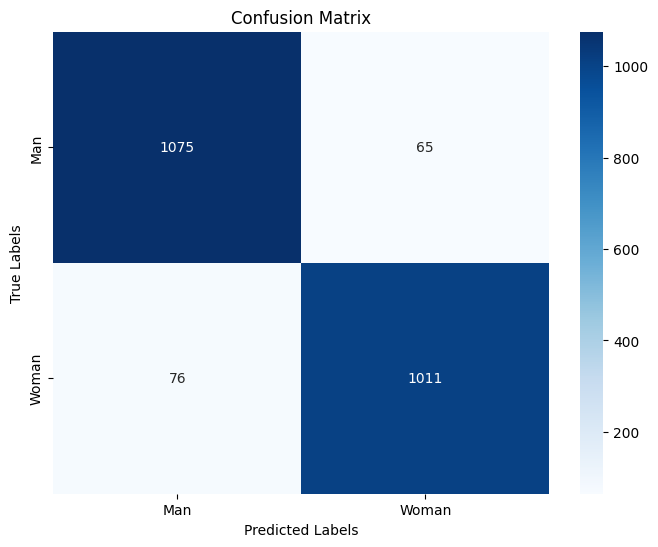

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Man", "Woman"], yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


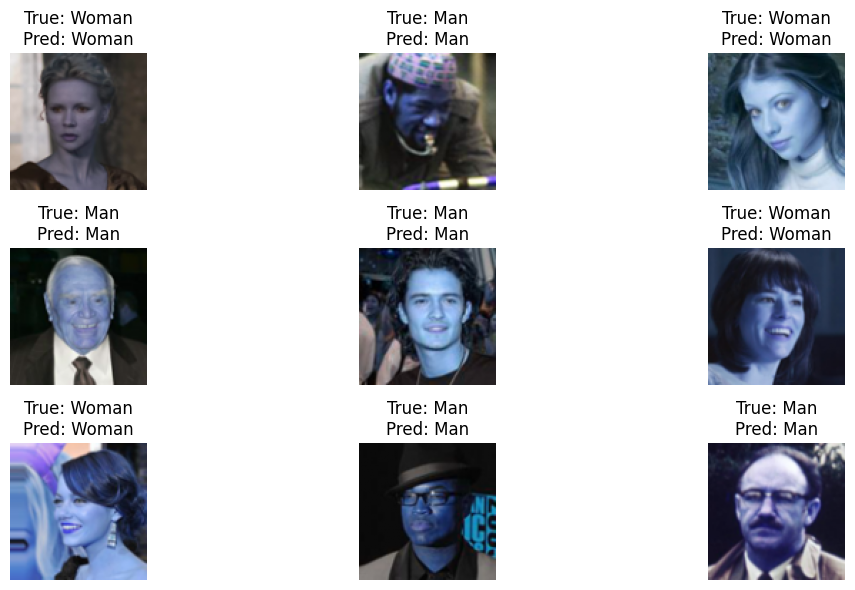

In [ ]:
# Display predictions on test images
plt.figure(figsize=(12, 6))
for i in range(9):
    idx = random.randint(0, len(testX) - 1)
    plt.subplot(3, 3, i + 1)
    plt.imshow((testX[idx] + 1) / 2)  # Rescale for display
    pred_label = 'Woman' if predY[idx] == 1 else 'Man'
    true_label = 'Woman' if trueY[idx] == 1 else 'Man'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('Images/test_predictions.png')
plt.show()

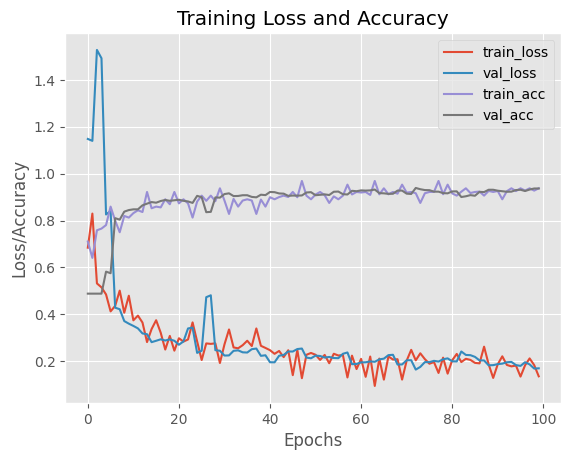

In [ ]:
# Plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Save the plot to disk
plt.savefig('Images/plot.png')